ModuleNotFoundError: No module named 'navipy.moving'

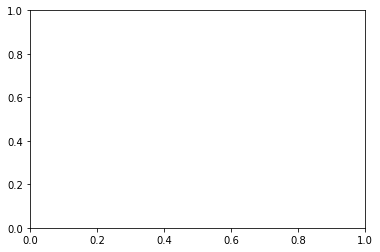

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

from navipy.processing.mcode import optic_flow
from navipy.maths.coordinates import cartesian_to_spherical
from navipy.moving.agent import posorient_columns
from navipy.moving.agent import velocities_columns
from navipy.scene import __spherical_indeces__

# Optic Flow

Optic flow is defined as the change of light in the image, e.g. on the retina or the camera’s sensor, due to a relative motion between the eye or camera and the scene.

In this section we focus on calculating the optic flow from the animal or camera motion and the distance to surrounding objects. Note, that in applied task, the problem of interest is the opposite of our current focus, namely the problem is how to find the animal or camera motion and the distance to surrounding objects from an estimate of the optic flow obtained from a series of images.

To avoid confusion between, we qualify the optic flow from known animal or camera motion and distance to surrounding objects as geometrical, and will call it geometrical optic flow or gOF. 

Koendering Van Dorn in their 1987 article 'Facts on optic flow' derive geometrical optic flow, and obtained the following equation

$$ gOF_i = -\mu_i(t-t. d_i)d_i)-R\times d_i $$

here 
* $gOF_i$ is the geometrical optic flow in the $i-th$ viewing direction $d_i$. 
* $t$ and $R$ are the translational and angular velocity, respectively. 
* $\mu_i$ is the nearness (inverse of the distance) to the closest object in the $i-th$ viewing direction

The equation can be rewritten by using the "apparent rotation" due to the translation $A_i=\mu_i di_i\times t$, and become

$$ gOF_i = -(A_i+R)\times d_i $$

The optic flow is thus the sum of apparent rotation due to the translation and the angular rotation projected to a plane orthogonal to the viewing direction. 

The eye is sometimes described as a spherical apparatus (espectially in insect research), here each viewing direction can be expressed in a spherical coordinate system. The gOF in a spherical system as three component, but the one along the viewing direction (i.e. the $\rho$ of the coordinate system) equates zero, because the gOF is othogonal to that direction.

In the remaining sections we will assume that the distance to close object have already been calculated (see renderering tutorials) and will only look at a single point along a trajectory at which the differences in x,y,z,and euler angles could be obtained. Furthermore we will use the yaw-pitch-roll (zyx) for the euler angles



In [2]:
convention='zyx'
tuples_posvel = posorient_columns(convention)
tuples_posvel.extend(velocities_columns(convention))
index_posvel = pd.MultiIndex.from_tuples(tuples_posvel,
                                         names=['position',
                                                'orientation'])
velocity = pd.Series(index=index_posvel, data=0)

# Define the eye
elevation = np.linspace(-np.pi/2,np.pi/2,11)
azimuth = np.linspace(-np.pi,np.pi,21)
[ma,me]=np.meshgrid(azimuth,elevation)
imshape = me.shape
viewing_directions = np.zeros((ma.shape[0], ma.shape[1], 2))
viewing_directions[..., __spherical_indeces__['elevation']] = me
viewing_directions[..., __spherical_indeces__['azimuth']] = ma
# Useful for quiver plots
vdir_az = viewing_directions[..., __spherical_indeces__['azimuth']]
vdir_el = viewing_directions[..., __spherical_indeces__['elevation']]
# Create a scene
scene = np.random.rand(imshape[0],imshape[1])

## Optic flow in an x,y plane

When the objects are at equidistances

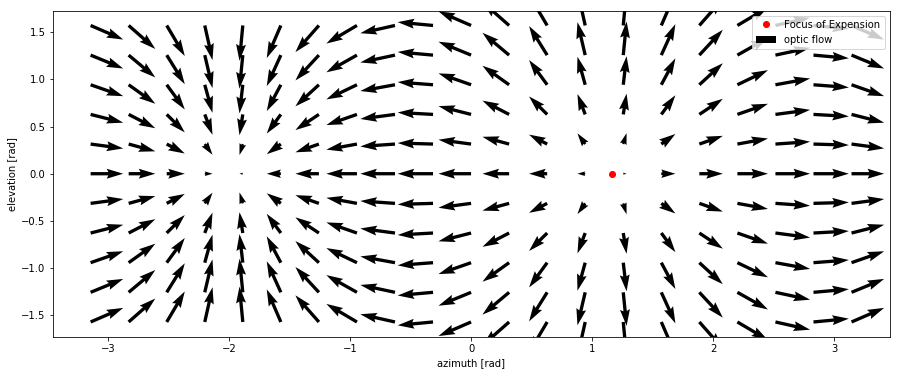

In [3]:
vel = velocity.copy() # to avoid overwright
vel.loc[('location','dx')]=np.random.randn()
vel.loc[('location','dy')]=np.random.randn()
sce = scene.copy() # to avoid overwright
sce = 0*sce + 10 # equidistant
# 
el,az,_=cartesian_to_spherical(vel.loc[('location','dx')],
                      vel.loc[('location','dy')],
                      vel.loc[('location','dz')])

plt.figure(figsize=(15,6))
rof, hof, vof= optic_flow(sce, viewing_directions, vel)
plt.quiver(vdir_az,vdir_el,hof,vof, label='optic flow')
plt.plot([az],[el],'ro', label='Focus of Expension')
plt.legend()
plt.xlabel('azimuth [rad]')
plt.ylabel('elevation [rad]');

With one object closer than the rest

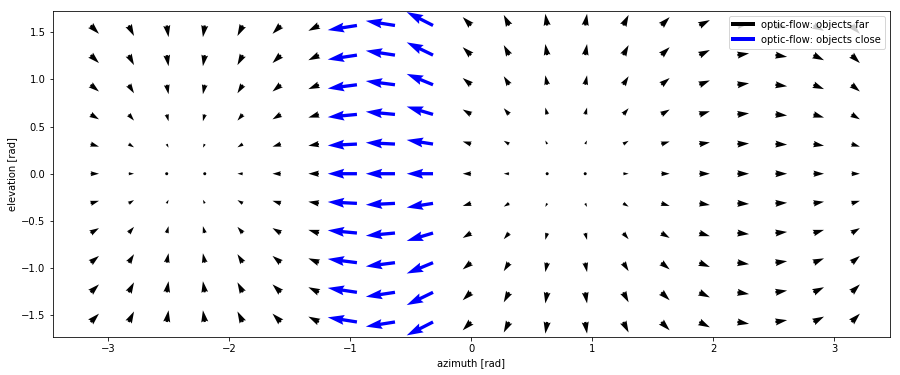

In [4]:
vel = velocity.copy() # to avoid overwright
vel.loc[('location','dx')]=1.0
vel.loc[('location','dy')]=1.0
sce = scene.copy() # to avoid overwright
sce = 0*sce + 20 # equidistant
azindeces = np.arange(7,10)
sce[:,azindeces,...]=8 # closer
# 
el,az,_=cartesian_to_spherical(vel.loc[('location','dx')],
                      vel.loc[('location','dy')],
                      vel.loc[('location','dz')])
colours = np.zeros((*vdir_az.shape,3), dtype=float)
colours[:,azindeces,2] = 1 # blue not transparent
colours = np.vstack([colours[...,channel].flatten() for channel in range(colours.shape[-1])])
colours = colours.transpose()

plt.figure(figsize=(15,6))
rof, hof, vof= optic_flow(sce, viewing_directions, vel)
plt.quiver(vdir_az.flatten(),vdir_el.flatten(),
           hof.flatten(),vof.flatten(), color=colours,
           label='optic flow', scale=5)

legend_elements = [Line2D([0], [0], color='k', lw=4, label='optic-flow: objects far'),
                   Line2D([0], [0], color='b', lw=4, label='optic-flow: objects close')]
plt.legend(handles=legend_elements)


plt.xlabel('azimuth [rad]')
plt.ylabel('elevation [rad]');

## Optic flow around the yaw axis

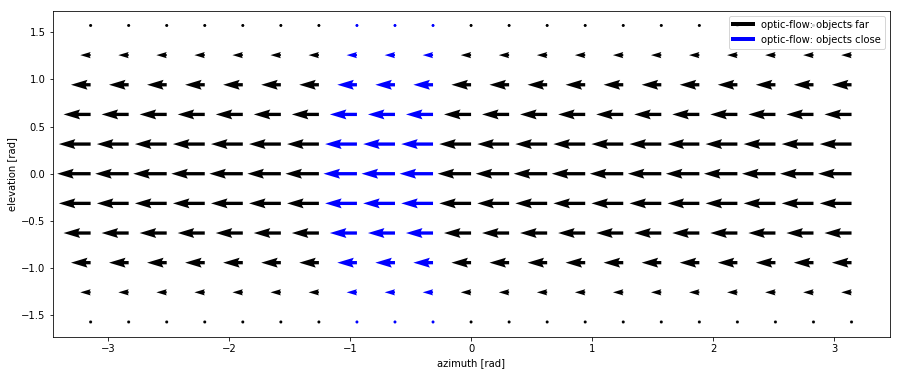

In [5]:
vel = velocity.copy() # to avoid overwright
vel.loc[(convention,'dalpha_2')]=0.2
sce = scene.copy() # to avoid overwright
sce = 0*sce + 20 # equidistant
azindeces = np.arange(7,10)
sce[:,azindeces,...]=8 # closer
# 
el,az,_=cartesian_to_spherical(vel.loc[('location','dx')],
                      vel.loc[('location','dy')],
                      vel.loc[('location','dz')])
colours = np.zeros((*vdir_az.shape,3), dtype=float)
colours[:,azindeces,2] = 1 # blue not transparent
colours = np.vstack([colours[...,channel].flatten() for channel in range(colours.shape[-1])])
colours = colours.transpose()

plt.figure(figsize=(15,6))
rof, hof, vof= optic_flow(sce, viewing_directions, vel)
plt.quiver(vdir_az.flatten(),vdir_el.flatten(),
           hof.flatten(),vof.flatten(), color=colours,
           label='optic flow', scale=5)

legend_elements = [Line2D([0], [0], color='k', lw=4, label='optic-flow: objects far'),
                   Line2D([0], [0], color='b', lw=4, label='optic-flow: objects close')]
plt.legend(handles=legend_elements)


plt.xlabel('azimuth [rad]')
plt.ylabel('elevation [rad]');

## Optic flow around the pitch axis

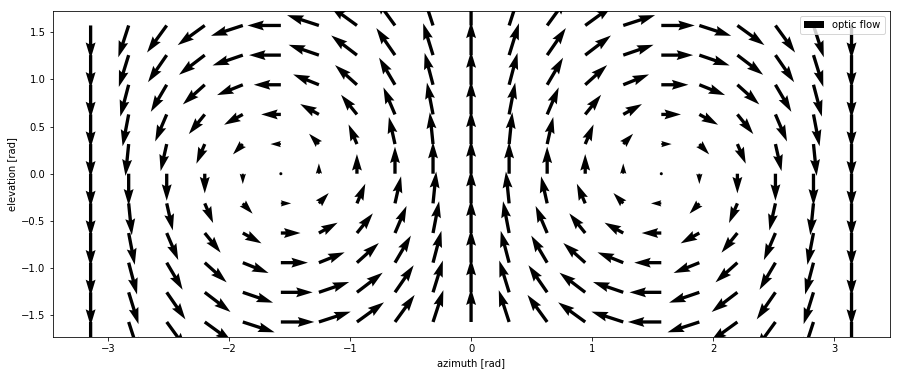

In [6]:
vel = velocity.copy() # to avoid overwright
vel.loc[(convention,'dalpha_1')]=0.2
sce = scene.copy() # to avoid overwright
# 
el,az,_=cartesian_to_spherical(vel.loc[('location','dx')],
                      vel.loc[('location','dy')],
                      vel.loc[('location','dz')])

plt.figure(figsize=(15,6))
rof, hof, vof= optic_flow(sce, viewing_directions, vel)
plt.quiver(vdir_az,vdir_el,hof,vof, label='optic flow', scale=5)
plt.legend()
plt.xlabel('azimuth [rad]')
plt.ylabel('elevation [rad]');

## Optic flow around the roll axis

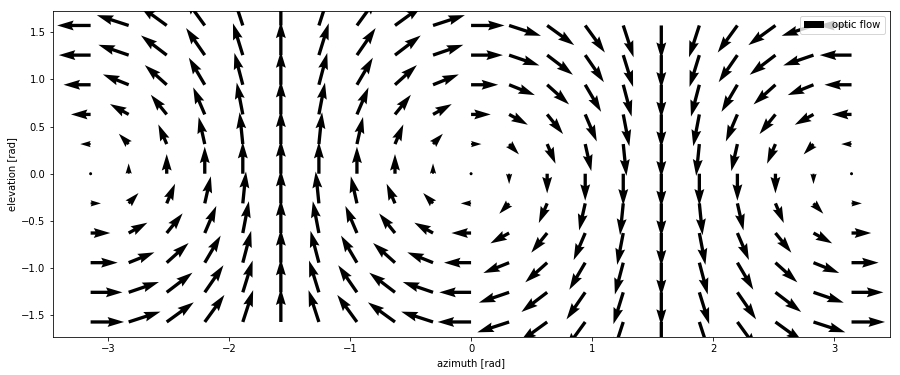

In [7]:
vel = velocity.copy() # to avoid overwright
vel.loc[(convention,'dalpha_0')]=0.2
sce = scene.copy() # to avoid overwright
# 
el,az,_=cartesian_to_spherical(vel.loc[('location','dx')],
                      vel.loc[('location','dy')],
                      vel.loc[('location','dz')])

plt.figure(figsize=(15,6))
rof, hof, vof= optic_flow(sce, viewing_directions, vel)
plt.quiver(vdir_az,vdir_el,hof,vof, label='optic flow', scale=5)
plt.legend()
plt.xlabel('azimuth [rad]')
plt.ylabel('elevation [rad]');

## Optic flow of relevant points

We consider N relevant points, named as follow

In [8]:
from navipy.trajectories import Trajectory
points_name = ['nest', '1', '2', '3', '4']
relevant_points = pd.Series(index=pd.MultiIndex.from_product([points_name,['x','y','z']]))
relevant_points.nest=[0,0,0] # [x,y,z] of the point
relevant_points['1']=[1,0,0]
relevant_points['2']=[-1,0,0]
relevant_points['3']=[0,1,0]
relevant_points['4']=[0,-1,0]

and want to calculate the optic flow of these point along the following trajectory

In [9]:
mytraj=Trajectory().read_hdf('../../../navipy/resources/sample_experiment/Doussot_2018a/bodybee05.hdf')

We convert the point from the world coordinate system to the bee coordinate system, and then express them in spherical coordinates, i.e. the coordinate system used in the optic_flow functions.

In [10]:
markers2bee = mytraj.world2body(relevant_points)

from navipy.maths.coordinates import cartesian_to_spherical
from navipy.scene import spherical_indeces
tmp=markers2bee.swaplevel(axis=1)
el,az,radius=cartesian_to_spherical(tmp.x,
                       tmp.y,
                       tmp.z)
markers2bee_sh = pd.DataFrame(index=markers2bee.index,
                             columns=markers2bee.columns)
d = dict(zip(['x','y','z'], ['elevation','azimuth','radius']))
markers2bee_sh = markers2bee_sh.rename(columns=d, level=1)
markers2bee_sh = markers2bee_sh.swaplevel(axis=1)
markers2bee_sh.elevation=el
markers2bee_sh.azimuth=az
markers2bee_sh.radius=radius
markers2bee_sh = markers2bee_sh.swaplevel(axis=1)

The optic flow not only need the trajectory, but also the differentiation of it, 
and merge traj with its velocity because the optic flow depend also of the agent orientation

In [11]:
mytrajvel = mytraj.velocity(frame='body')
mytrajvel.dropna().head()

location                             zyx                    
             dx         dy         dz  dalpha_0  dalpha_1  dalpha_2
0                                                                  
1446  56.219964 -31.224126  20.132479  0.072558  0.095589 -0.030482
1447  56.964958 -34.094871  12.393126 -0.093171 -0.085802  0.021423
1448  56.156138 -31.763273  20.419316 -0.014716  0.145675 -0.052279
1449  55.721923 -28.312013  26.486477  0.244976 -0.022581  0.052578
1450  55.073491 -34.323865  20.455256 -0.258412  0.040791  0.012399

We loop through all time point in the velocity and calculate the optic flow of the selected
points.

In [12]:
my_opticflow=pd.DataFrame(index=mytrajvel.index,
                          columns=pd.MultiIndex.from_product([points_name,['rof','hof','vof']]))
my_opticflow=my_opticflow.swaplevel(axis=1)
tmp = markers2bee_sh.swaplevel(axis=1)
for ii, velocity in mytrajvel.dropna().iterrows():
    # get the elevation, azimuth of the seen point of interest
    # and the distance to it
    elevation = tmp.loc[ii,'elevation']
    azimuth = tmp.loc[ii,'azimuth']
    distance = tmp.loc[ii,'radius'].values
    # Build viewing direction of all objects
    viewing_dir = np.zeros((elevation.shape[0],2))
    viewing_dir[...,spherical_indeces()['elevation']] = elevation
    viewing_dir[...,spherical_indeces()['azimuth']] = azimuth
    # Calculate the optic flow of these points
    rof,hof,vof = optic_flow(distance,viewing_dir,velocity)
    # save the results in df
    my_opticflow.loc[ii,'rof']=rof
    my_opticflow.loc[ii,'hof']=hof
    my_opticflow.loc[ii,'vof']=vof
# swap level again, to index optic flow with point of interest
my_opticflow=my_opticflow.swaplevel(axis=1)

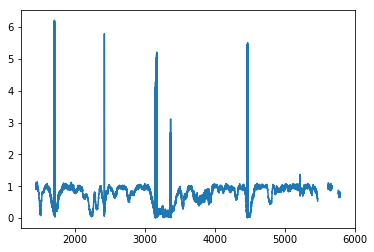

In [17]:
fig=plt.figure()
ax=fig.gca()
of_norm = my_opticflow.swaplevel(axis=1).hof**2+my_opticflow.swaplevel(axis=1).vof**2
of_norm = np.sqrt(of_norm.astype(float))
ax.plot(of_norm.nest)

## Optic flow from a database

Database of rendered views along a trajectory can be created by using the tool `blendalongtraj`. Once the database has been created, optic flow can be obtain by using the difference in the position orientation and the distance to surrounding objects (The 'D' channel).

In [14]:
import pkg_resources
from navipy.database import DataBase
from navipy.trajectories import Trajectory
import time
mydbfile = pkg_resources.resource_filename(
    'navipy', 'resources/database.db')
mydb = DataBase(mydbfile)
mytraj = Trajectory().from_dataframe(mydb.posorients)
mytrajvel =  mytraj.velocity(frame='body')
mytrajvel.dropna().head()

location              zyx                 location               zyx  \
               x     y  z alpha_0 alpha_1 alpha_2       dx    dy dz dalpha_0   
frame_i                                                                        
1.0        -0.25  -0.5  3       0       0       0     0.25     0  0        0   
2.0            0  -0.5  3       0       0       0     0.25     0  0        0   
3.0         0.25  -0.5  3       0       0       0     0.25     0  0        0   
4.0          0.5  -0.5  3       0       0       0     0.25     0  0        0   
5.0         -0.5 -0.25  3       0       0       0       -1  0.25  0        0   

                           
        dalpha_1 dalpha_2  
frame_i                    
1.0            0        0  
2.0            0        0  
3.0            0        0  
4.0            0        0  
5.0            0        0

### without multiprocessing

In [15]:
t_start = time.time()
horizontal_of = np.zeros((mytrajvel.shape[0],*mydb.viewing_directions[...,0].shape))
vertical_of = horizontal_of.copy()

for ii, (frame_i, velocity) in enumerate(mytrajvel.dropna().iterrows()):
    scene = mydb.scene(velocity)
    distance = scene[...,3,0]
    # Calculate the optic flow of these points
    _,hof,vof = optic_flow(distance,mydb.viewing_directions,velocity)
    # save the results in df
    horizontal_of[ii,...]=hof
    vertical_of[ii,...]=vof
    
t_elapse = time.time()-t_start

print('Optic flow was calculated on {} frame in {}s'.format(mytrajvel.dropna().shape[0],
                                                            t_elapse))

Optic flow was calculated on 24 frame in 1.5818347930908203s


### with mulitprocessing

In [16]:
from multiprocessing import Pool
from functools import partial

def calc_optic_flow(ii,dbfile,trajvel):
    db = DataBase(dbfile)
    velocity = trajvel.iloc[ii,:]
    scene = db.scene(velocity)
    distance = scene[...,3,0]
    # Calculate the optic flow of these points
    _,hof,vof = optic_flow(distance,db.viewing_directions,velocity)
    return (ii, hof, vof)

t_start = time.time()

indeces = list(np.arange(mytrajvel.dropna().shape[0]))
with Pool() as p:
    result = p.map(
            partial(calc_optic_flow,
                    dbfile=mydbfile,
                    trajvel=mytrajvel.dropna()),
            indeces)
# Place results in a usable array
nb_of = len(result)
size_of = result[0][1].shape

horizontal_of = np.zeros((nb_of,*size_of))
vertical_of = horizontal_of.copy()
for flow in result:
    ii = flow[0]
    horizontal_of[ii,...]=flow[1]
    vertical_of[ii,...]=flow[2]
    
t_elapse = time.time()-t_start

print('Optic flow was calculated on {} frame in {}s'.format(mytrajvel.dropna().shape[0],
                                                            t_elapse))

Optic flow was calculated on 24 frame in 0.5883920192718506s


## Remarks

### misconception about rotational optic flow

In the formulation of the optic flow the angular velocity $R$ of the animal is used. This velocity is a vector expressed in the animal coordinates system, and is **not** equal to the vector formed by the differentiation of the euler angles between two time points $t$ and $t-1$, i.e. $[yaw(t)-yaw(t-1),pitch(t)-pitch(t-1),roll(t)-roll(t-1)]$, because each euler angle is the rotation from one frame to the next frame, and only the final frame correspond to the coordinate system of the bee. It implies for the optic flow, that an arbitrary orientation, if droll is not zero, we can not expect the optic flow to be a rotation around the bee x-axis. 

### Calculating the translational and rotational optic flow

It may be sometimes interesting to look at the optic flow field as the animal would have experience if it would not have rotated or translated. In other words it may be interesting to look at the translational and rotational optic flow instead of the full optic flow. 

In `navipy` you can calculate such optic flow by using `optic_flow_translational` and `optic_flow_rotational`.